Business Understanding
---
I'd like to answer the following questions:<br> <br>
"Can you describe the vibe of each Boston neighborhood using listing descriptions?"<br>
"Is there a correlation between a number of reviews and average rating?"<br>
"What kind of review component correlate most with an overal rating?"<br>

- For that we'll need to analyze 2 datasets - listings and reviews. 
- We'll need to apply some semantical analysis to descriptions to get summary on what each neighborhood / listing vibe might be.




Data Understanding and Data Preparation
---
To understand the dataset we need to complete data preparation
- ensure that the data is in the suitable format
- decide how to deal with missing values
- add extra features if needed


In [1]:
# lets start with importing libraries needed
import pandas as pd
import numpy as np
from collections import Counter
import datetime as dt
import nltk
from nltk import ngrams
import folium
import plotly.graph_objects as go
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)


In [25]:
# Importing dataset for listings
df_listings=pd.read_csv('/Users/olegmonahov/Downloads/listings.csv')
df_listings.head(5)

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview        ...          \
0  Roslindale is quiet, convenient and friendly. ...        ...           
1  The room is in Roslindale, a diverse and prima...        ...           
2  The LOCATION: Roslindale is a safe and diverse...        ...           
3  Roslindale is a lovely little neighborhood loc...        ...           
4  I love the proximity to downtown, the neighbor...        ...           

  review_scores_value requires_license license jurisdiction_names  \
0                 NaN                f     NaN                NaN   
1                 9.0                f     NaN                NaN   
2                10.0                f     NaN                NaN   
3                10.0                f     NaN                NaN   
4                10.0                f     NaN                NaN   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                t            moderate                             f   
2                f            moderate                             t   
3                f            moderate                             f   
4                f            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

   reviews_per_month  
0                NaN  
1               1.30  
2               0.47  
3               1.00  
4               2.25  

[5 rows x 95 columns]

In [24]:
# Importing dataset for reviews
df_reviews=pd.read_csv('/Users/olegmonahov/Downloads/reviews.csv')
df_reviews.head()

listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

<h3>Data prepartion for "reviews" dataset </h3>

In [35]:
# checking types of objects in the dataset

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
listing_id       68275 non-null int64
id               68275 non-null int64
date             68275 non-null object
reviewer_id      68275 non-null int64
reviewer_name    68275 non-null object
comments         68222 non-null object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


<b>Data Formats </b><br>
In order to keep the dataset in the format suitable for caclulations and modelling we need to: 
- convert Date to Datetime values
- storing everything else as objects is fine as long as we are going to transform it to text at some point 

In [36]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'], format='%Y/%m/%d')


In [37]:
df_reviews.head()

listing_id       id       date  reviewer_id reviewer_name  \
0     1178162  4724140 2013-05-21      4298113       Olivier   
1     1178162  4869189 2013-05-29      6452964     Charlotte   
2     1178162  5003196 2013-06-06      6449554     Sebastian   
3     1178162  5150351 2013-06-15      2215611        Marine   
4     1178162  5171140 2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [38]:
# checking formats again
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
listing_id       68275 non-null int64
id               68275 non-null int64
date             68275 non-null datetime64[ns]
reviewer_id      68275 non-null int64
reviewer_name    68275 non-null object
comments         68222 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.1+ MB


<b>Checking null values <b>

In [39]:
np.sum(df_reviews.isnull())

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         53
dtype: int64

As we don't really need any rows without comments we can just safely delete them (there are only 53 of them)

In [40]:
df_reviews.dropna(axis=0, how='any',inplace=True)

In [41]:
np.sum(df_reviews.isnull())

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [42]:
# checking the value counts after deletion
df_reviews.count()

listing_id       68222
id               68222
date             68222
reviewer_id      68222
reviewer_name    68222
comments         68222
dtype: int64

In [83]:
# checking if there are any duplicate ids for comments
df_reviews.groupby('id')['id'].nunique().max()


1

<h3>Data prepartion for "listings" dataset </h3>

In [59]:
df_listings.head(3)

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1  3075044   https://www.airbnb.com/rooms/3075044   20160906204935   
2  6976      https://www.airbnb.com/rooms/6976      20160906204935   

  last_scraped                               name  \
0  2016-09-07   Sunny Bungalow in the City          
1  2016-09-07   Charming room in pet friendly apt   
2  2016-09-07   Mexican Folk Art Haven in Boston    

                                                                                                                                                                                                                                                     summary  \
0  Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.   
1  Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly.     
2  Come stay with a friendly, middle-aged guy in the safe and quiet Roslindale neighborhood of Boston. You will have you own clean, furnished room (with cable TV, Wi-Fi, and a desk to work at) in an apartment that is filled with Mexican folk art.         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      space  \
0  The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1  Small but cozy and quite room with a full size bed. Ample street parking.                                                                                                                                                                                                                                                                                                                                                                                                                

In [44]:
# checking types of objects in the dataset

df_listings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

we see a huge list of available features for data sets. However, for a purpose of our analysis we don't need them all. we just need Rating specific information, neighborhood attributes like name and location. Therefore I suggest looking at just a subset of features here 

<ul>
    
    
<li>id</li>
<li>latitude</li>
<li>longitude</li>
<li>neighbourhood_group_cleansed</li>
<li>neighbourhood_cleansed</li>
<li>neighbourhood</li>
<li>zipcode</li>
<li>reviews_per_month</li>
<li>review_scores_rating</li>
<li>review_scores_accuracy</li>
<li>review_scores_cleanliness</li>
<li>review_scores_checkin</li>
<li>review_scores_communication</li>
<li>review_scores_location</li>
<li>review_scores_value</li>
<li>requires_license  </li>

</ul>

Creating a smaller dataframe consisting only of columns we need

In [74]:
df_listings=df_listings[['id','latitude','longitude','neighbourhood_cleansed',
             'reviews_per_month','review_scores_rating','review_scores_location','review_scores_value']]


In [75]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 8 columns):
id                        3585 non-null int64
latitude                  3585 non-null float64
longitude                 3585 non-null float64
neighbourhood_cleansed    3585 non-null object
reviews_per_month         2829 non-null float64
review_scores_rating      2772 non-null float64
review_scores_location    2763 non-null float64
review_scores_value       2764 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 224.1+ KB


<b>Data Formats </b><br>
as I don't see any issues with data formats, We'll leave them as they are

<b>Checking null values </b><br>


In [76]:
np.sum(df_listings.isnull())

id                        0  
latitude                  0  
longitude                 0  
neighbourhood_cleansed    0  
reviews_per_month         756
review_scores_rating      813
review_scores_location    822
review_scores_value       821
dtype: int64

we see that around 30% of data is missing values for reviews per month and review rating. though this is quite a lot of reviews to replace with dummy variables, we still can do it, because this is a secondary set of  

In [ ]:
df_listings[pd.isnull(df_listings.reviews_per_month)]

In [69]:
df_listings.head(4)

id   latitude  longitude neighbourhood_cleansed neighbourhood  \
0  12147973  42.282619 -71.133068  Roslindale             Roslindale     
1  3075044   42.286241 -71.134374  Roslindale             Roslindale     
2  6976      42.292438 -71.135765  Roslindale             Roslindale     
3  1436513   42.281106 -71.121021  Roslindale             NaN            

  zipcode  reviews_per_month  review_scores_rating  review_scores_accuracy  \
0  02131  NaN                NaN                   NaN                       
1  02131   1.30               94.0                  10.0                     
2  02131   0.47               98.0                  10.0                     
3  NaN     1.00               100.0                 10.0                     

   review_scores_cleanliness  review_scores_checkin  \
0 NaN                        NaN                      
1  9.0                        10.0                    
2  9.0                        10.0                    
3  10.0                       10.0                    

   review_scores_communication  review_scores_location  review_scores_value  
0 NaN                          NaN                     NaN                   
1  10.0                         9.0                     9.0                  
2  10.0                         9.0                     10.0                 
3  10.0                         10.0                    10.0

In [84]:
# checking if there are any duplicates in ids
df_listings.groupby('id')['id'].nunique().max()


1

In [102]:
df_listings.reviews_per_month.mean()

1.970908448214916

In [123]:
# replacing null values

df_listings['reviews_per_month']=df_listings['reviews_per_month'].fillna(df_listings['reviews_per_month'].mean())
df_listings['review_scores_rating']=df_listings['review_scores_rating'].fillna(df_listings['review_scores_rating'].mean())
df_listings['review_scores_location']=df_listings['review_scores_location'].fillna(df_listings['review_scores_location'].mean())
df_listings['review_scores_value']=df_listings['review_scores_value'].fillna(df_listings['review_scores_value'].mean())

In [127]:
df_listings.head()

id   latitude  longitude neighbourhood_cleansed  reviews_per_month  \
0  12147973  42.282619 -71.133068  Roslindale             1.970908            
1  3075044   42.286241 -71.134374  Roslindale             1.300000            
2  6976      42.292438 -71.135765  Roslindale             0.470000            
3  1436513   42.281106 -71.121021  Roslindale             1.000000            
4  7651065   42.284512 -71.136258  Roslindale             2.250000            

   review_scores_rating  review_scores_location  review_scores_value  
0  90.076456             9.359655                9.107448             
1  94.000000             9.000000                9.000000             
2  98.000000             9.000000                10.000000            
3  100.000000            10.000000               10.000000            
4  99.000000             9.000000                10.000000

In [129]:
# checking for null values again 
np.sum(df_listings.isnull())

id                        0
latitude                  0
longitude                 0
neighbourhood_cleansed    0
reviews_per_month         0
review_scores_rating      0
review_scores_location    0
review_scores_value       0
dtype: int64

<b>Merging review and listings table to one resulting dataframe<b>

In [26]:
df=pd.merge(df_reviews, df_listings, left_on='listing_id', right_on='id', how='left')

In a lot of cases, there is more than one review for a given listing. In order to get aggregated results for each listing, we need first to collect all the reviews on it in one column. We'll do it by pivoting the resulting dataset with aggregating function being a list string of all comments for that listing 

In [179]:
pivot_table = df.pivot_table(index=['listing_id'],
                                     values='comments',
                                     aggfunc=lambda x: ' '.join(x))

In [181]:
pivot_table.tail()

comments
listing_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
14813006    This place is beautiful, every decoration makes perfect sense. My group of 14 people stayed here for a few nights and we are extremely happy we chose this apartment. Everything was SUPER CLEAN and new!!! We were able to park in front of the building without a problem which is a big plus, it's FREE PARKING in all the neighborhood. We used the full equipped kitchen and made a lot of meals, also the communication with the hosts was superb and smooth. There's a beautiful park in front of the apartment where I took my little niece for a walk, she loved it. Also the balcony is very pretty too, we had some wine and enjoyed the sunset. Overall, our experience was fantastic! We totally recommend this place to everybody! Thank you guys for making our have a perfect stay!!! 
14823724    The check in process was easy, and the unit itself was in an excellent location.  Very easy to get to public transportation (on a bus stop or one block to the green line).  It was a true Boston living experience!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
14842237    The host canceled this reservation 10 days before arrival. This is an automated posting.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
14843050    Victor was a fantastic host, and his place was lovely. Accurate to pictures and in a great location! The host canceled this reservation 19 days before arrival. This is an automated posting.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
14843783    Alex's place was perfect amazing view super 

<h4>Building tags arrays for each of the listings</h4>
In order to provide a quick overview on individual placement features, we need to build the list of tags for each listing. The list of tags would be the most frequenly used adjectives from the comments, as in my opinion having these few adjectives helps a lot in understanding the property features ('cozy, spacious, posh)
to do that we need to accomplish the following:
<br>
- tokenize each of the comments
<br>
- define part of speech for each of the words
<br>
- count the frequency of usage for each of the words in each listing comment array
<br>
- filter only top most frequently used adjectives



In [ ]:

def tokenize(text_sample):
    """
Description: This function is used to read the input (text _sample) and 
produce list of tags associated with this sample. Tags are the list of 7 most common adjectives
in text sample.
Arguments:
    text_sample: a text containing all the comments  

Returns:
    tags: an array containing  7 most common adjectives in text sample.
"""
    
#     making sure that we provide data of comment as the list 
    comments = text_sample.split()
    
#     building dictionary from the comments

    cnt = Counter(comments)

#     sorting frequency

    ngram=sorted([(k,v) for k,v in cnt.items()], key=lambda x : x[1])
    
#     creating empty dictionary 


    ngram_dictionary = {k: None for k in ngram}

#     tokenizing words and adding part of speech 

    for i in ngram_sorted:
        tokenize=i[0]
        tokens = nltk.word_tokenize(tokenize)
        tagged = nltk.pos_tag(tokens)
        ngram_dictionary[i] = tagged[0][1]

#     new dictionary to filter only adectives ('JJ') and limiting to 7 most frequent one

    newDict = dict(filter(lambda elem: elem[1] == 'JJ', ngram_dict.items()))
    newDict_clean=dict(Counter(newDict).most_common(7))
    tags=[]

#     filtering out meaningless common adjectives and creating a new column with tags 

    for k, v in newDict_clean.items():
        if(k[0] not in ['much','few','nice','great','good','next','such']) :
            tags.append((k[0]))
    return tags




Let's copy a dataframe and add tags column

In [328]:
df_sample=pivot_table.iloc[:,:]
df_sample['tags']=df_sample['comments'].apply(tokenize)

Now that we got tag data, it's time to create a resulting dataframe where we'll have coordinates and tags in one place

In [335]:
df_result=pd.merge(df_listings, df_sample, left_on='id', right_on='listing_id', how='left')

In [339]:
df_result.head()

id   latitude  longitude neighbourhood_cleansed  reviews_per_month  \
0  12147973  42.282619 -71.133068  Roslindale             1.970908            
1  3075044   42.286241 -71.134374  Roslindale             1.300000            
2  6976      42.292438 -71.135765  Roslindale             0.470000            
3  1436513   42.281106 -71.121021  Roslindale             1.000000            
4  7651065   42.284512 -71.136258  Roslindale             2.250000            

   review_scores_rating  review_scores_location  review_scores_value  \
0  90.076456             9.359655                9.107448              
1  94.000000             9.000000                9.000000              
2  98.000000             9.000000                10.000000             
3  100.000000            10.000000               10.000000             
4  99.000000             9.000000                10.000000             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Transforming tags data to string format - just for easier manipulation fro adding it on Follium map

In [401]:
df_result1_str=[]
col_str=lambda x: ' '.join(x)
for x in df_result['tags']:
    try:
        df_result1_str.append(col_str(x))
    except:
        df_result1_str.append('None')

# adding text tags
df_result['tags_str']=df_result1_str

<h2>Visualizing tags data </h2> <br>
Now we have everything ready for visulizing data. In order to add tags for some dots on the map, we'll be using powerful Folium library

In [343]:
# some Boston coordinates to build folium on
latitude=42.282619
longitude=-71.133068

In [346]:
# using just a subset of data to avoid long execution time

df_result1=df_result.iloc[:100,:]

In [410]:

# create map of Boston using latitude and longitude values
map_airbnb_data = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(df_result1['latitude'], df_result1['longitude'], df_result1['new_tags']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_airbnb_data)  


    
map_airbnb_data


<h3>Researching correlations between total score and it's components</h3>
<br>
As a final excercise for this task we'll answer questions:<br>
- "What kind of review component correlate most with an overal rating?"<br>
- "Is there a correlation between a number of reviews and average rating?"<br>

To answer the question on which review components correlate most with the rating we'll be using the correlation heatmap, based on Matplotlib pyplot function. 



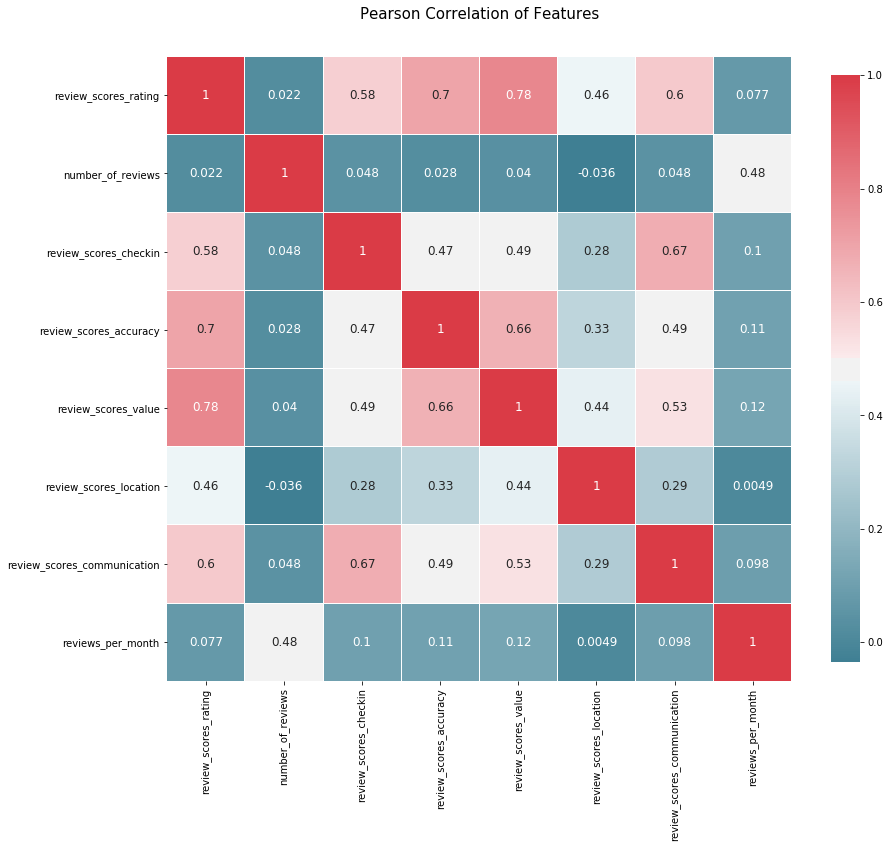

In [21]:
data1=df_listings[['review_scores_rating','number_of_reviews','review_scores_checkin','review_scores_accuracy','review_scores_value','review_scores_location','review_scores_communication','reviews_per_month']].copy(deep = True)
#correlation heatmap of dataset
def correlation_heatmap(df):
     """
Description: This function is used to read the input (dataframe) and 
produce correlation coefficient for all the numeric features in the dataframe
Arguments:
    df: a dataframe containing numeric values

Returns:
    plt.plot: a matrix with correlation coefficient values
"""
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

As we can see there are some review components that have a strong correlation with overal review. Those components are: Value, Accuracy, Communication. From looking at this large datasets we can make a conclusion that a host aiming to increase the overal rating should try to improve these features

As the last question for this excercise, we'll answer "Is there a correlation between a number of reviews and average rating?"<br>
In order to do that, we'll use Plotly Go library, building standard scatter chart for reviews_per_month and review_scores_value features

In [22]:


N = 100000
fig = go.Figure(data=go.Scattergl(
    x = df_listings['review_scores_rating'],
    y = df_listings['reviews_per_month'],
    mode='markers',
    marker=dict(
        color=np.random.randn(N),
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

As we can see, there is an upward trend in number of reviews along with the average score increase. That may impose correlation between these 2 values. However, if we take a look at the actual correlation coeficient we can see that it's only 0.12. That means though visually it looks like correlation exists, by checking corr value we can clearly dissaprove this point. Number of reviews per month doesn't imply that the likelihood that the property is better increases. The outliers we see at the chart for high values of rating is just due to the fact that the more reviews you get, the better likelihood that you get good ones 